# ARIMAX Modeling

### Import libraries and read in data

In [367]:
#Import libraries.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import acf, plot_acf, plot_pacf
from statsmodels.tsa.api import VAR
from statsmodels.tsa.arima_model import ARIMA

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from pylab import rcParams


%matplotlib inline

import warnings
warnings.simplefilter(action="ignore")
warnings.filterwarnings("ignore")

In [368]:
# model_df_sc = pd.read_csv('./Data/model_df_sc.csv')
# model_df_sc['Date'] = pd.to_datetime(model_df_sc['Date'])
# model_df_sc.set_index('Date', inplace=True)
# model_df_sc.sort_index(inplace=True)
# model_df_sc.head()

In [369]:
# Reading in saved dataframe from 1_EDA_DC_Covid.ipynb and 2_Feature_Engineering.ipynb
model_df = pd.read_csv('./Data/model_df.csv')

# Setting Date index
model_df['Date'] = pd.to_datetime(model_df['Date'])
model_df.set_index('Date', inplace=True)
model_df.sort_index(inplace=True)
model_df.head()

,Ward_1_Cases,Ward_2_Cases,Ward_3_Cases,Ward_4_Cases,Ward_5_Cases,Ward_6_Cases,Ward_7_Cases,Ward_8_Cases,Avg_Temp
Date,,,,,,,,,
2020-04-01,10.0,13.0,3.0,11.0,7.0,11.0,6.0,7.0,47.6
2020-04-02,9.0,6.0,4.0,12.0,15.0,18.0,17.0,7.0,54.0
2020-04-03,16.0,13.0,2.0,27.0,24.0,24.0,21.0,18.0,56.8
2020-04-04,7.0,0.0,4.0,10.0,4.0,2.0,13.0,25.0,54.4
2020-04-05,12.0,15.0,6.0,23.0,10.0,31.0,21.0,7.0,57.1


In [370]:
# Standardizing all values from model_df and saving it as a new dataframe 
ss = StandardScaler()
ss = ss.fit(model_df)
model_df_sc = ss.transform(model_df)

scaled_cols = ['Ward_1_Scaled', 'Ward_2_Scaled', 'Ward_3_Scaled', 'Ward_4_Scaled', 'Ward_5_Scaled',
              'Ward_6_Scaled', 'Ward_7_Scaled', 'Ward_8_Scaled', 'Avg_Temp_Scaled']

model_df_sc = pd.DataFrame(model_df_sc, columns=scaled_cols, index=model_df.index)
model_df_sc.head()

,Ward_1_Scaled,Ward_2_Scaled,Ward_3_Scaled,Ward_4_Scaled,Ward_5_Scaled,Ward_6_Scaled,Ward_7_Scaled,Ward_8_Scaled,Avg_Temp_Scaled
Date,,,,,,,,,
2020-04-01,-0.367615,0.469052,-0.510369,-0.513593,-0.743528,-0.252121,-0.734432,-0.654435,-1.052801
2020-04-02,-0.453168,-0.311813,-0.349920,-0.448674,-0.178042,0.236170,0.090620,-0.654435,-0.618239
2020-04-03,0.145703,0.469052,-0.670817,0.525115,0.458131,0.654704,0.390639,0.126766,-0.428119
2020-04-04,-0.624273,-0.981126,-0.349920,-0.578513,-0.955586,-0.879922,-0.209399,0.623894,-0.591079
2020-04-05,-0.196509,0.692156,-0.029023,0.265438,-0.531471,1.142994,0.390639,-0.654435,-0.407749


### Augmented Dickey Fuller Test

In [371]:
# Function infers whether data is stationary according to the p-value extracted from 
# Augmented Dickey Fuller test.

def get_p_value_adfuller(df, alpha=0.05):
    
    for col in df.columns:
        
        dftest = adfuller(df[col])
    
        if dftest[1] >= alpha:
            print(f'p-value for {col} is {dftest[1]} (greater than alpha {alpha}). Infer data is not stationary.\n')
           
        else:
            print(f'p-value for {col} is {dftest[1]} (smaller than alpha {alpha}). Infer data is stationary.\n')

#### ADF on Scaled Data

In [372]:
# None of the variables from the original model_df_sc dataframe appear stationary from the ADF test
get_p_value_adfuller(model_df)

p-value for Ward_1_Cases is 0.7377726355911143 (greater than alpha 0.05). Infer data is not stationary.

p-value for Ward_2_Cases is 0.880339519202876 (greater than alpha 0.05). Infer data is not stationary.

p-value for Ward_3_Cases is 0.9783440609162188 (greater than alpha 0.05). Infer data is not stationary.

p-value for Ward_4_Cases is 0.7039304479629689 (greater than alpha 0.05). Infer data is not stationary.

p-value for Ward_5_Cases is 0.5383978060792163 (greater than alpha 0.05). Infer data is not stationary.

p-value for Ward_6_Cases is 0.9820970708776997 (greater than alpha 0.05). Infer data is not stationary.

p-value for Ward_7_Cases is 0.8834473281257176 (greater than alpha 0.05). Infer data is not stationary.

p-value for Ward_8_Cases is 0.9055492910659728 (greater than alpha 0.05). Infer data is not stationary.

p-value for Avg_Temp is 0.9320838184316186 (greater than alpha 0.05). Infer data is not stationary.



In [373]:
# The ADF test results infer that differencing the dataframe once makes all variables stationary. 
get_p_value_adfuller(model_df.diff().dropna())

p-value for Ward_1_Cases is 1.1418968835082987e-20 (smaller than alpha 0.05). Infer data is stationary.

p-value for Ward_2_Cases is 2.0435517516522828e-20 (smaller than alpha 0.05). Infer data is stationary.

p-value for Ward_3_Cases is 3.687967736948437e-07 (smaller than alpha 0.05). Infer data is stationary.

p-value for Ward_4_Cases is 1.8899110384490464e-25 (smaller than alpha 0.05). Infer data is stationary.

p-value for Ward_5_Cases is 6.25156274445401e-22 (smaller than alpha 0.05). Infer data is stationary.

p-value for Ward_6_Cases is 7.41786081826415e-11 (smaller than alpha 0.05). Infer data is stationary.

p-value for Ward_7_Cases is 5.156062722161494e-12 (smaller than alpha 0.05). Infer data is stationary.

p-value for Ward_8_Cases is 0.0016383842566233865 (smaller than alpha 0.05). Infer data is stationary.

p-value for Avg_Temp is 2.7878450527609255e-13 (smaller than alpha 0.05). Infer data is stationary.



#### ADF on Scaled Data

In [374]:
# None of the variables from the original model_df_sc dataframe appear stationary from the ADF test
get_p_value_adfuller(model_df_sc)

p-value for Ward_1_Scaled is 0.7377726355910978 (greater than alpha 0.05). Infer data is not stationary.

p-value for Ward_2_Scaled is 0.8803395192028715 (greater than alpha 0.05). Infer data is not stationary.

p-value for Ward_3_Scaled is 0.9783440609162204 (greater than alpha 0.05). Infer data is not stationary.

p-value for Ward_4_Scaled is 0.7039304479629617 (greater than alpha 0.05). Infer data is not stationary.

p-value for Ward_5_Scaled is 0.5383978060792187 (greater than alpha 0.05). Infer data is not stationary.

p-value for Ward_6_Scaled is 0.9820970708777005 (greater than alpha 0.05). Infer data is not stationary.

p-value for Ward_7_Scaled is 0.8834473281257176 (greater than alpha 0.05). Infer data is not stationary.

p-value for Ward_8_Scaled is 0.9055492910659664 (greater than alpha 0.05). Infer data is not stationary.

p-value for Avg_Temp_Scaled is 0.9320838184316185 (greater than alpha 0.05). Infer data is not stationary.



In [375]:
# The ADF test results infer that differencing the dataframe once makes all variables stationary. 
get_p_value_adfuller(model_df_sc.diff().dropna())

p-value for Ward_1_Scaled is 1.1418968835084713e-20 (smaller than alpha 0.05). Infer data is stationary.

p-value for Ward_2_Scaled is 2.043551751652239e-20 (smaller than alpha 0.05). Infer data is stationary.

p-value for Ward_3_Scaled is 3.687967736949315e-07 (smaller than alpha 0.05). Infer data is stationary.

p-value for Ward_4_Scaled is 1.8899110384489655e-25 (smaller than alpha 0.05). Infer data is stationary.

p-value for Ward_5_Scaled is 6.251562744454237e-22 (smaller than alpha 0.05). Infer data is stationary.

p-value for Ward_6_Scaled is 7.417860818263338e-11 (smaller than alpha 0.05). Infer data is stationary.

p-value for Ward_7_Scaled is 5.156062722159832e-12 (smaller than alpha 0.05). Infer data is stationary.

p-value for Ward_8_Scaled is 0.0016383842566225124 (smaller than alpha 0.05). Infer data is stationary.

p-value for Avg_Temp_Scaled is 2.7878450527608447e-13 (smaller than alpha 0.05). Infer data is stationary.



### Train Test Split

In [13]:
# Splitting the model_df_sc data into train and test datasets
train_sc, test_sc = train_test_split(model_df_sc, train_size = 0.85, shuffle = False)

In [277]:
# Splitting the model_df data into train and test datasets
train, test = train_test_split(model_df, train_size = 0.85, shuffle = False)

In [367]:
# # Function returns a line plot with different colors indicating train vs test data
# def train_test_plot(train, test, title='Title'):
    
#     plt.figure(figsize=(16, 8))
    
#     plt.plot(train[train.columns[0]], c='red')
#     plt.plot(train[train.columns[1]], c='green')

#     plt.plot(test[test.columns[0]], c='blue')
#     plt.plot(test[test.columns[1]], c='orange')
    
#     plt.title(title, fontsize=22)
    
#     plt.legend([train.columns[0]+'_train', train.columns[1]+'_train', test.columns[0]+'_test', \
#                 test.columns[1]+'_test']);

In [330]:
# train_test_plot(train, test, 'Train/Test Data for Scaled Ward 1 Cases and Avg Temp')

### Grid Searching for p and q Values to Use in ARIMAX Model

In [286]:
# This function manually grid searches through p and q values to use when fitting an
# ARIMAX model, ultimately identifying the combination that provides the smallest AIC score. 

def grid_search_p_and_q(endog, exog, p_list, q_list):
    # Starting AIC, p, and q.
    best_aic = 100_000_000
    best_p = 0
    best_q = 0
    for p in p_list:
        print(f'{p} out of {len(p_list)} complete')
        for q in q_list:
            try:
#                 print(f'Attempting to fit ARIMA({p},1,{q})')
                arimax = ARIMA(endog = endog.astype(float).dropna(),
                              exog = exog,
                              order = (p,1,q))
                model = arimax.fit()
#                 print(f'The AIC for ARIMA({p},1,{q}) is: {model.aic}')
                if model.aic < best_aic:

                    best_aic = model.aic
                    best_p = p
                    best_q = q

            except:
                pass
            
    order = (best_p, 1, best_q)
    
    print()
    print(f'FINISHED: ARIMAX({order}) gives the smallest AIC when fitted with the training data.')
    print(f'This model has an AIC of {best_aic}.')
    return order

In [287]:
p_q_gs_ward_1_scaled = grid_search_p_and_q(endog = train_sc['Ward_1_Scaled'], 
                                           exog = train_sc['Avg_Temp_Scaled'], 
                                           p_list = range(6), 
                                           q_list = range(6))

0 out of 6 complete
1 out of 6 complete
2 out of 6 complete
3 out of 6 complete
4 out of 6 complete
5 out of 6 complete

FINISHED: ARIMAX((5, 1, 2)) gives the smallest AIC when fitted with the training data.
This model has an AIC of 459.3614133836578.


In [289]:
p_q_gs_ward_2_scaled = grid_search_p_and_q(endog = train_sc['Ward_2_Scaled'], 
                                    exog = train_sc['Avg_Temp_Scaled'], 
                                    p_list = range(6), 
                                    q_list = range(6))

0 out of 6 complete
1 out of 6 complete
2 out of 6 complete
3 out of 6 complete
4 out of 6 complete
5 out of 6 complete

FINISHED: ARIMAX((4, 1, 5)) gives the smallest AIC when fitted with the training data.
This model has an AIC of 415.18671833858406.


In [290]:
p_q_gs_ward_3_scaled = grid_search_p_and_q(endog = train_sc['Ward_3_Scaled'], 
                                    exog = train_sc['Avg_Temp_Scaled'], 
                                    p_list = range(6), 
                                    q_list = range(6))

0 out of 6 complete
1 out of 6 complete
2 out of 6 complete
3 out of 6 complete
4 out of 6 complete
5 out of 6 complete

FINISHED: ARIMAX((5, 1, 1)) gives the smallest AIC when fitted with the training data.
This model has an AIC of 477.7687988800852.


In [291]:
p_q_gs_ward_4_scaled = grid_search_p_and_q(endog = train_sc['Ward_4_Scaled'], 
                                    exog = train_sc['Avg_Temp_Scaled'], 
                                    p_list = range(6), 
                                    q_list = range(6))

0 out of 6 complete
1 out of 6 complete
2 out of 6 complete
3 out of 6 complete
4 out of 6 complete
5 out of 6 complete

FINISHED: ARIMAX((2, 1, 4)) gives the smallest AIC when fitted with the training data.
This model has an AIC of 446.3884723372166.


In [292]:
p_q_gs_ward_5_scaled = grid_search_p_and_q(endog = train_sc['Ward_5_Scaled'], 
                                    exog = train_sc['Avg_Temp_Scaled'], 
                                    p_list = range(6), 
                                    q_list = range(6))

0 out of 6 complete
1 out of 6 complete
2 out of 6 complete
3 out of 6 complete
4 out of 6 complete
5 out of 6 complete

FINISHED: ARIMAX((4, 1, 3)) gives the smallest AIC when fitted with the training data.
This model has an AIC of 389.24837808232184.


In [293]:
p_q_gs_ward_6_scaled = grid_search_p_and_q(endog = train_sc['Ward_6_Scaled'], 
                                    exog = train_sc['Avg_Temp_Scaled'], 
                                    p_list = range(6), 
                                    q_list = range(6))

0 out of 6 complete
1 out of 6 complete
2 out of 6 complete
3 out of 6 complete
4 out of 6 complete
5 out of 6 complete

FINISHED: ARIMAX((0, 1, 3)) gives the smallest AIC when fitted with the training data.
This model has an AIC of 302.98776141034006.


In [294]:
p_q_gs_ward_7_scaled = grid_search_p_and_q(endog = train_sc['Ward_7_Scaled'], 
                                    exog = train_sc['Avg_Temp_Scaled'], 
                                    p_list = range(6), 
                                    q_list = range(3))

0 out of 6 complete
1 out of 6 complete
2 out of 6 complete
3 out of 6 complete
4 out of 6 complete
5 out of 6 complete

FINISHED: ARIMAX((4, 1, 2)) gives the smallest AIC when fitted with the training data.
This model has an AIC of 430.2185066032611.


In [295]:
p_q_gs_ward_8_scaled = grid_search_p_and_q(endog = train_sc['Ward_8_Scaled'], 
                                    exog = train_sc['Avg_Temp_Scaled'], 
                                    p_list = range(3), 
                                    q_list = range(6))

0 out of 3 complete
1 out of 3 complete
2 out of 3 complete

FINISHED: ARIMAX((2, 1, 5)) gives the smallest AIC when fitted with the training data.
This model has an AIC of 445.4421689406426.


### Standard Forecast Predictions

In [296]:
def get_arimax_forecast(train, test, endog_var, exog_var, order, forecast_steps):
    
    # Setting endogenous variable values to use when fitting model
    endog_train = train[endog_var]
    
    # Setting exogenous variable values to use when fitting model
    exog_train = train[exog_var]
    
    # Setting exogenous variable values to compare with the model's predictions
    exog_test = test[exog_var]
    
    # Fitting ARIMAX model
    arimax = ARIMA(endog = endog_train, 
                  exog = exog_train,
                  dates = train.index, 
                  order = order).fit()
    
    # Forecasting endogenous variable values
    arimax_forecast = arimax.forecast(steps = forecast_steps, exog=exog_test)
    
    return arimax_forecast[0]

In [172]:
# Function to transform scaled predictions back to the scale of the original dataframe
def inverse_transform_preds(original_var, original_df, scaled_preds, index):
    
    feature = original_df[original_var].values.reshape(-1, 1)
    ss = StandardScaler()
    feat_scaled = ss.fit_transform(feature)
    predictions = ss.inverse_transform(scaled_preds)
    predictions = pd.Series(predictions, index=index)
    
    return predictions

In [278]:
ward_1_arimax_forecast_scaled = get_arimax_forecast(train_sc, test_sc,
                                             endog_var = 'Ward_1_Scaled',
                                             exog_var = 'Avg_Temp_Scaled',
                                             order=p_q_gs_ward_1_scaled,
                                             forecast_steps=len(test_sc))

ward_1_inverse_forecast = inverse_transform_preds('Ward_1_Cases', 
                                                   model_df, 
                                                   scaled_preds = ward_1_arimax_forecast_scaled, 
                                                   index = test_sc.index)

In [279]:
ward_2_arimax_forecast_scaled = get_arimax_forecast(train_sc, test_sc, endog_var = 'Ward_2_Scaled', 
                                             exog_var = 'Avg_Temp_Scaled', 
                                             order=p_q_gs_ward_2_scaled, 
                                             forecast_steps=len(test_sc))

ward_2_inverse_forecast = inverse_transform_preds('Ward_2_Cases', 
                                                   model_df, 
                                                   scaled_preds = ward_2_arimax_forecast_scaled, 
                                                   index = test_sc.index)

In [280]:
ward_3_arimax_forecast_scaled = get_arimax_forecast(train_sc, test_sc, endog_var = 'Ward_3_Scaled', 
                                             exog_var = 'Avg_Temp_Scaled', 
                                             order=p_q_gs_ward_3_scaled, 
                                             forecast_steps=len(test_sc))

ward_3_inverse_forecast = inverse_transform_preds('Ward_3_Cases', 
                                                   model_df, 
                                                   scaled_preds = ward_3_arimax_forecast_scaled, 
                                                   index = test_sc.index)

In [281]:
ward_4_arimax_forecast_scaled = get_arimax_forecast(train_sc, test_sc, endog_var = 'Ward_4_Scaled', 
                                             exog_var = 'Avg_Temp_Scaled', 
                                             order=p_q_gs_ward_4_scaled, 
                                             forecast_steps=len(test_sc))

ward_4_inverse_forecast = inverse_transform_preds('Ward_4_Cases', 
                                                   model_df, 
                                                   scaled_preds = ward_4_arimax_forecast_scaled, 
                                                   index = test_sc.index)

In [282]:
ward_5_arimax_forecast_scaled = get_arimax_forecast(train_sc, test_sc, endog_var = 'Ward_5_Scaled', 
                                             exog_var = 'Avg_Temp_Scaled', 
                                             order=p_q_gs_ward_5_scaled, 
                                             forecast_steps=len(test_sc))

ward_5_inverse_forecast = inverse_transform_preds('Ward_5_Cases', 
                                                   model_df, 
                                                   scaled_preds = ward_5_arimax_forecast_scaled, 
                                                   index = test_sc.index)

In [283]:
ward_6_arimax_forecast_scaled = get_arimax_forecast(train_sc, test_sc, endog_var = 'Ward_6_Scaled', 
                                             exog_var = 'Avg_Temp_Scaled', 
                                             order=p_q_gs_ward_6_scaled, 
                                             forecast_steps=len(test_sc))

ward_6_inverse_forecast = inverse_transform_preds('Ward_6_Cases', 
                                                   model_df, 
                                                   scaled_preds = ward_6_arimax_forecast_scaled, 
                                                   index = test_sc.index)

In [284]:
ward_7_arimax_forecast_scaled = get_arimax_forecast(train_sc, test_sc, endog_var = 'Ward_7_Scaled', 
                                             exog_var = 'Avg_Temp_Scaled', 
                                             order=p_q_gs_ward_7_scaled, 
                                             forecast_steps=len(test_sc))

ward_7_inverse_forecast = inverse_transform_preds('Ward_7_Cases', 
                                                   model_df, 
                                                   scaled_preds = ward_7_arimax_forecast_scaled, 
                                                   index = test_sc.index)

In [285]:
ward_8_arimax_forecast_scaled = get_arimax_forecast(train_sc, test_sc, endog_var = 'Ward_8_Scaled', 
                                             exog_var = 'Avg_Temp_Scaled', 
                                             order=p_q_gs_ward_8_scaled, 
                                             forecast_steps=len(test_sc))

ward_8_inverse_forecast = inverse_transform_preds('Ward_8_Cases', 
                                                   model_df, 
                                                   scaled_preds = ward_8_arimax_forecast_scaled, 
                                                   index = test_sc.index)

### Rolling Forecast Predictions

In [336]:
def get_rolling_scaled_preds(train, test, endog_var, exog_var, order):

    predictions = []
    history_endog = list(train[endog_var])
    history_exog = list(train[exog_var])
    test_endog = test[endog_var]
    test_exog = test[exog_var]

    for t in range(len(test)):
        for p in p_list:
            for q in q_list:
                order = (p,1,q)
                model_fit = ARIMA(endog=history_endog,
                                  exog=history_exog,
                                  dates=train.index,
                                  order=order).fit()
                yhat = model_fit.forecast(steps=1, exog=test_exog[t])[0][0]
                predictions.append(yhat)
                history_endog.append(test_endog[t])
                history_exog.append(test_exog[t])

    return predictions

## This worked really well -- takes a long time, be careful

In [254]:
ward_1_rolling_scaled_preds = get_rolling_scaled_preds(train_sc,
                                                       test_sc, 
                                                       endog_var = 'Ward_1_Scaled',
                                                       exog_var = 'Avg_Temp_Scaled',
                                                       order = (2,1,5))

ward_1_inverse_sc_preds = inverse_transform_preds('Ward_1_Cases', 
                                                   model_df, 
                                                   scaled_preds = ward_1_rolling_scaled_preds, 
                                                   index = test_sc.index)

In [253]:
ward_2_rolling_scaled_preds = get_rolling_scaled_preds(train_sc,
                                                       test_sc, 
                                                       endog_var = 'Ward_2_Scaled',
                                                       exog_var = 'Avg_Temp_Scaled',
                                                       order = p_q_gs_ward_2_scaled)

ward_2_inverse_sc_preds = inverse_transform_preds('Ward_2_Cases', 
                                                   model_df, 
                                                   scaled_preds = ward_2_rolling_scaled_preds, 
                                                   index = test_sc.index)

In [255]:
ward_3_rolling_scaled_preds = get_rolling_scaled_preds(train_sc,
                                                       test_sc, 
                                                       endog_var = 'Ward_3_Scaled',
                                                       exog_var = 'Avg_Temp_Scaled',
                                                       order = p_q_gs_ward_3_scaled)

ward_3_inverse_sc_preds = inverse_transform_preds('Ward_3_Cases', 
                                                   model_df, 
                                                   scaled_preds = ward_3_rolling_scaled_preds, 
                                                   index = test_sc.index)

In [248]:
ward_4_rolling_scaled_preds = get_rolling_scaled_preds(train_sc,
                                                       test_sc, 
                                                       endog_var = 'Ward_4_Scaled',
                                                       exog_var = 'Avg_Temp_Scaled',
                                                       order = (2,1,5))

ward_4_inverse_sc_preds = inverse_transform_preds('Ward_4_Cases', 
                                                   model_df, 
                                                   scaled_preds = ward_4_rolling_scaled_preds, 
                                                   index = test_sc.index)

In [256]:
ward_5_rolling_scaled_preds = get_rolling_scaled_preds(train_sc,
                                                       test_sc, 
                                                       endog_var = 'Ward_5_Scaled',
                                                       exog_var = 'Avg_Temp_Scaled',
                                                       order = p_q_gs_ward_5_scaled)

ward_5_inverse_sc_preds = inverse_transform_preds('Ward_5_Cases', 
                                                   model_df, 
                                                   scaled_preds = ward_5_rolling_scaled_preds, 
                                                   index = test_sc.index)

In [257]:
ward_6_rolling_scaled_preds = get_rolling_scaled_preds(train_sc,
                                                       test_sc, 
                                                       endog_var = 'Ward_6_Scaled',
                                                       exog_var = 'Avg_Temp_Scaled',
                                                       order = p_q_gs_ward_6_scaled)

ward_6_inverse_sc_preds = inverse_transform_preds('Ward_6_Cases', 
                                                   model_df, 
                                                   scaled_preds = ward_6_rolling_scaled_preds, 
                                                   index = test_sc.index)

In [260]:
ward_7_rolling_scaled_preds = get_rolling_scaled_preds(train_sc,
                                                       test_sc, 
                                                       endog_var = 'Ward_7_Scaled',
                                                       exog_var = 'Avg_Temp_Scaled',
                                                       order = p_q_gs_ward_7_scaled)

ward_7_inverse_sc_preds = inverse_transform_preds('Ward_7_Cases', 
                                                   model_df, 
                                                   scaled_preds = ward_7_rolling_scaled_preds, 
                                                   index = test_sc.index)

In [266]:
ward_8_rolling_scaled_preds = get_rolling_scaled_preds(train_sc,
                                                       test_sc, 
                                                       endog_var = 'Ward_8_Scaled',
                                                       exog_var = 'Avg_Temp_Scaled',
                                                       order = (0,1,5))

ward_8_inverse_sc_preds = inverse_transform_preds('Ward_8_Cases', 
                                                   model_df, 
                                                   scaled_preds = ward_8_rolling_scaled_preds, 
                                                   index = test_sc.index)

### Plot ARIMAX Results

In [358]:
def plot_std_and_roll_preds(train, test, ward_no, std_preds, roll_preds):
    
    plt.figure(figsize=(14, 7))
    
    plt.subplot(211)
    plt.plot(train[f'Ward_{str(ward_no)}_Cases'])
    plt.plot(test[f'Ward_{str(ward_no)}_Cases'])
    plt.plot(std_preds)
    plt.ylabel('Daily Cases', fontsize=14)
    plt.legend(['Train Values', 'Test Values', 'Predictions'], loc='upper left')
    plt.title(f'Ward {str(ward_no)} Daily Cases One-Time Predictions vs Actual', fontsize=20)
    
    plt.subplot(212)
    plt.plot(train[f'Ward_{str(ward_no)}_Cases'])
    plt.plot(test[f'Ward_{str(ward_no)}_Cases'])
    plt.plot(roll_preds)
    plt.ylabel('Daily Cases', fontsize=14)
    plt.legend(['Train Values', 'Test Values', 'Predictions'], loc='upper left')
    plt.title(f'Ward {str(ward_no)} Daily Cases Rolling Predictions vs Actual', fontsize=20)
    
    plt.tight_layout();

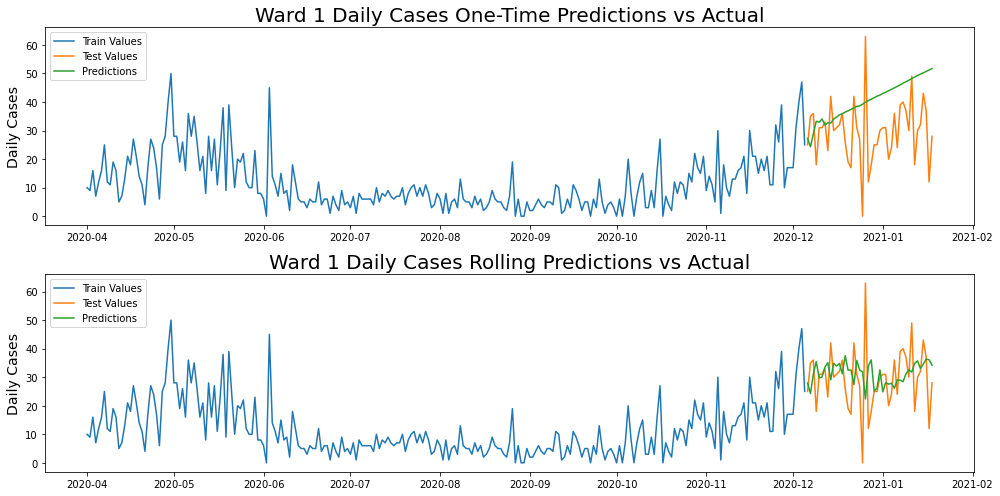

In [359]:
plot_std_and_roll_preds(train, test, 1, std_preds= ward_1_inverse_forecast, 
                        roll_preds = ward_1_inverse_sc_preds)

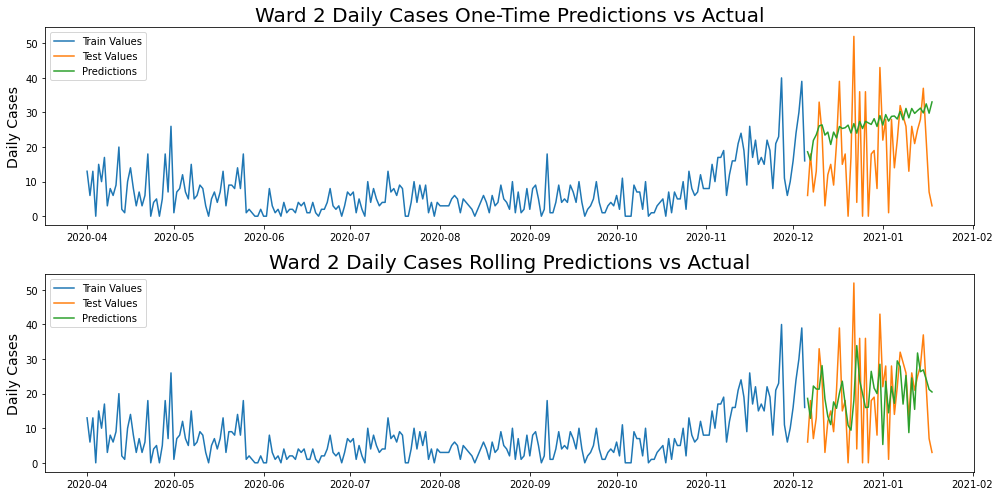

In [360]:
plot_std_and_roll_preds(train, test, 2, std_preds= ward_2_inverse_forecast, 
                        roll_preds = ward_2_inverse_sc_preds)

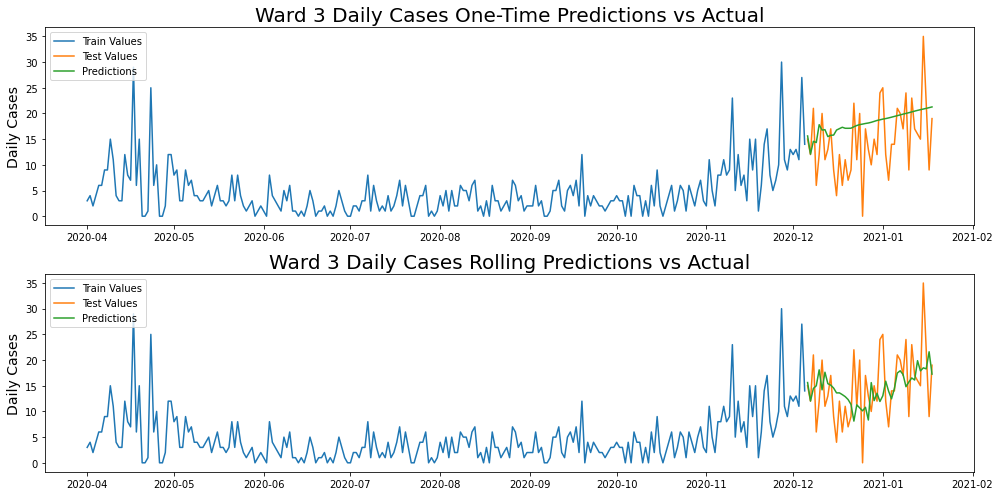

In [361]:
plot_std_and_roll_preds(train, test, 3, std_preds= ward_3_inverse_forecast, 
                        roll_preds = ward_3_inverse_sc_preds)

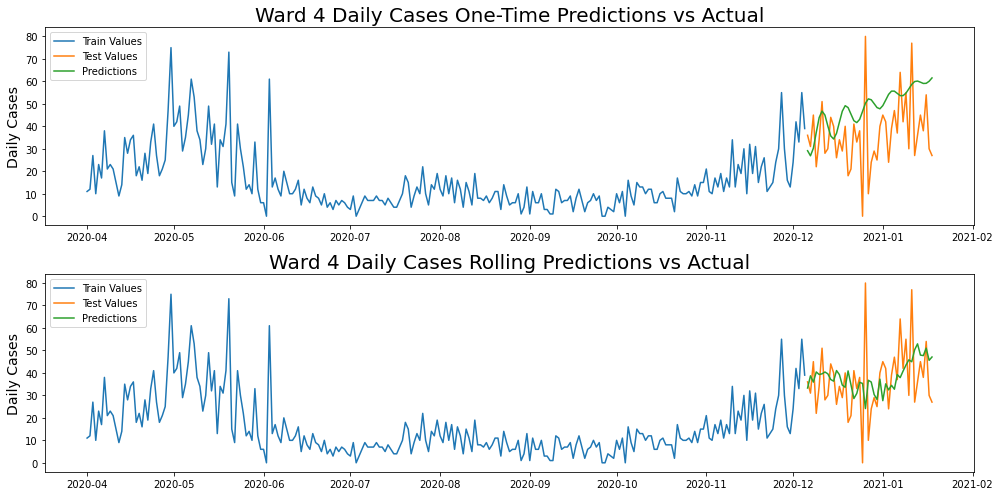

In [362]:
plot_std_and_roll_preds(train, test, 4, std_preds= ward_4_inverse_forecast, 
                        roll_preds = ward_4_inverse_sc_preds)

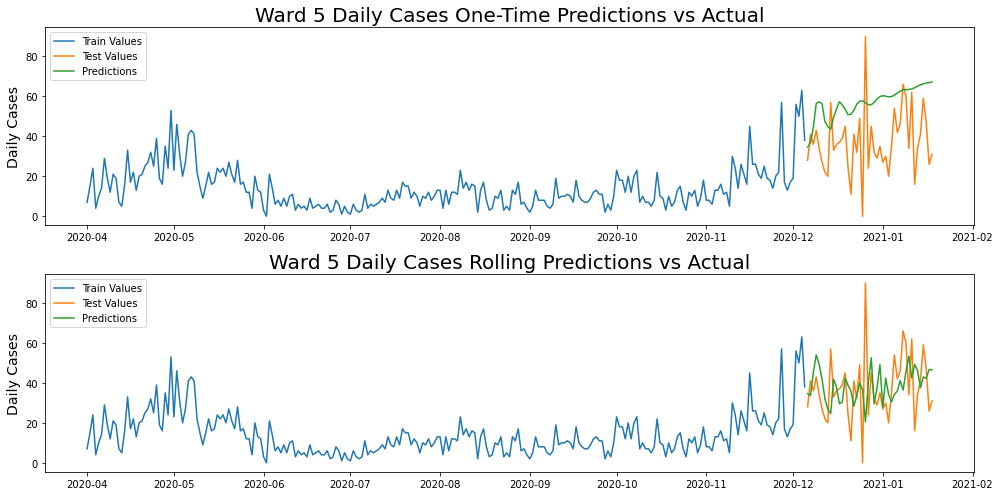

In [363]:
plot_std_and_roll_preds(train, test, 5, std_preds= ward_5_inverse_forecast, 
                        roll_preds = ward_5_inverse_sc_preds)

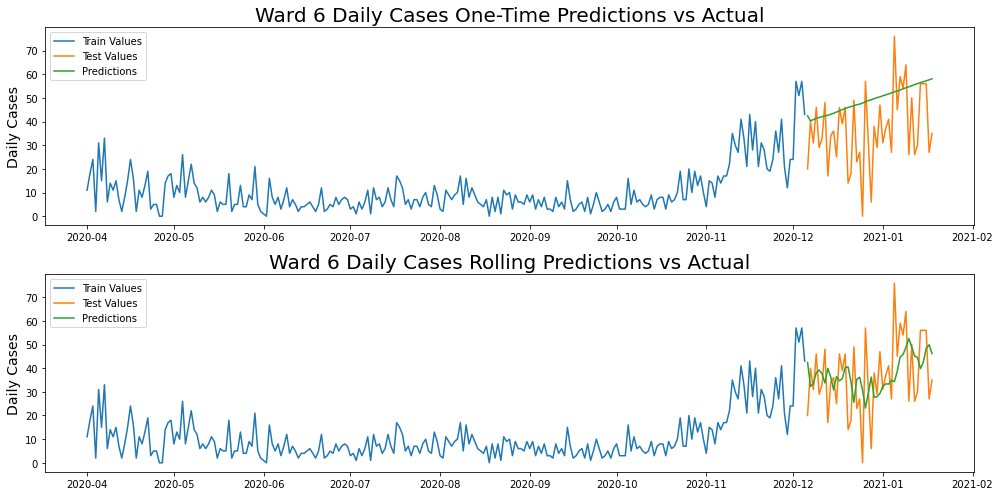

In [364]:
plot_std_and_roll_preds(train, test, 6, std_preds= ward_6_inverse_forecast, 
                        roll_preds = ward_6_inverse_sc_preds)

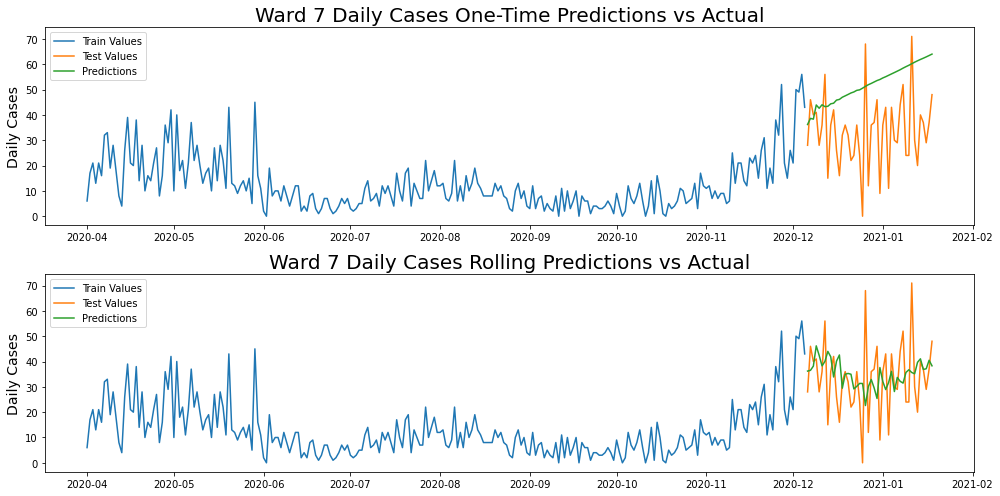

In [365]:
plot_std_and_roll_preds(train, test, 7, std_preds= ward_7_inverse_forecast, 
                        roll_preds = ward_7_inverse_sc_preds)

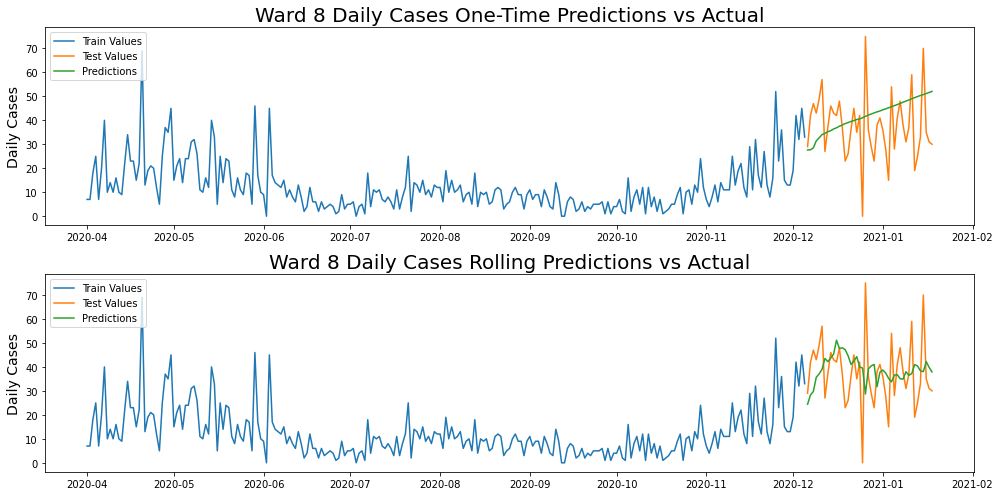

In [366]:
plot_std_and_roll_preds(train, test, 8, std_preds= ward_8_inverse_forecast, 
                        roll_preds = ward_8_inverse_sc_preds)

### Get RMSE for Each Ward

In [305]:
def get_rmse_scores(test, ward_list):
    
    ward_pred_dict = {1:[ward_1_inverse_forecast, ward_1_inverse_sc_preds], 
                      2:[ward_2_inverse_forecast, ward_2_inverse_sc_preds], 
                      3:[ward_3_inverse_forecast, ward_3_inverse_sc_preds], 
                      4:[ward_4_inverse_forecast, ward_4_inverse_sc_preds], 
                      5:[ward_5_inverse_forecast, ward_5_inverse_sc_preds], 
                      6:[ward_6_inverse_forecast, ward_6_inverse_sc_preds], 
                      7:[ward_7_inverse_forecast, ward_7_inverse_sc_preds], 
                      8:[ward_8_inverse_forecast, ward_8_inverse_sc_preds]}
        
    for ward in ward_list:
        for key, pred in ward_pred_dict.items():
            if ward == key:
                
                rmse_forecast = mean_squared_error(test[f'Ward_{str(ward)}_Cases'], pred[0], squared=False)
                rmse_rolling_pred = mean_squared_error(test[f'Ward_{str(ward)}_Cases'], pred[1], squared=False)
                
                if rmse_forecast > rmse_rolling_pred:
                    print(f'Standard forecasts RMSE for Ward {ward}: {rmse_forecast}')
                    print(f'Rolling predictions RMSE for Ward {ward}: {rmse_rolling_pred}')
                    print(f'ROLLING PREDICTIONS GIVE LOWER ERROR FOR {ward}')
                    print('--'*30)
                    print()
                else:
                    print(f'Standard forecast RMSE for Ward {ward}: {rmse_forecast}')
                    print(f'Rolling predictions RMSE for Ward {ward}: {rmse_rolling_pred}')
                    print(f'STANDARD FORECASTS GIVE LOWER ERROR FOR WARD {ward}')
                    print('--'*30)
                    print()

In [306]:
get_rmse_scores(test, [1, 2, 3, 4, 5, 6, 7, 8])

Standard forecasts RMSE for Ward 1: 16.616457449929744
Rolling predictions RMSE for Ward 1: 12.567729224296354
ROLLING PREDICTIONS GIVE LOWER ERROR FOR 1
------------------------------------------------------------

Standard forecasts RMSE for Ward 2: 14.044908104221815
Rolling predictions RMSE for Ward 2: 12.38959682056096
ROLLING PREDICTIONS GIVE LOWER ERROR FOR 2
------------------------------------------------------------

Standard forecasts RMSE for Ward 3: 7.078177931771391
Rolling predictions RMSE for Ward 3: 6.6806148680308395
ROLLING PREDICTIONS GIVE LOWER ERROR FOR 3
------------------------------------------------------------

Standard forecasts RMSE for Ward 4: 19.883034229117474
Rolling predictions RMSE for Ward 4: 16.323216123477486
ROLLING PREDICTIONS GIVE LOWER ERROR FOR 4
------------------------------------------------------------

Standard forecasts RMSE for Ward 5: 25.427009671549563
Rolling predictions RMSE for Ward 5: 18.403497997634563
ROLLING PREDICTIONS GIVE LO

In [341]:
# ward_8_inverse_sc_preds

In [342]:
# test['Ward_8_Cases']

In [343]:
# ward_8_inverse_forecast

In [349]:
resids_1 = test['Ward_1_Cases'] - ward_1_inverse_sc_preds
resids_2 = test['Ward_2_Cases'] - ward_2_inverse_sc_preds
resids_3 = test['Ward_3_Cases'] - ward_3_inverse_sc_preds
resids_4 = test['Ward_4_Cases'] - ward_4_inverse_sc_preds
resids_5 = test['Ward_5_Cases'] - ward_5_inverse_sc_preds
resids_6 = test['Ward_6_Cases'] - ward_6_inverse_sc_preds
resids_7 = test['Ward_7_Cases'] - ward_7_inverse_sc_preds
resids_8 = test['Ward_8_Cases'] - ward_8_inverse_sc_preds

In [350]:
def plot_resids(ward_no, resids):
    
    plt.figure(figsize=(18,7))

    # Create residual scatterplot
    plt.scatter(test.index, resids, c ='green')

    # Plot horizontal line at y=0.
    plt.hlines(y = 0,
               xmin = test.index.min(),
               xmax = test.index.max(),
               linestyles = '--')

    # Set labels and axes.
    plt.title(f'Modeling Net New Daily Cases -- Prediction Errors for Ward {str(ward_no)}', fontsize=20)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.ylabel('Residuals', fontsize = 16);

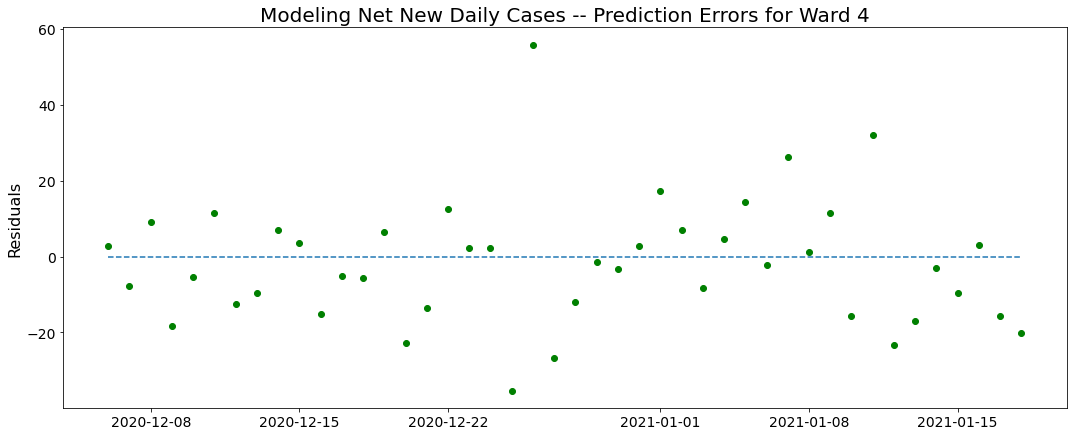

In [355]:
plot_resids(4, resids_4)

### Trash Below

In [545]:
# ward_4_arimax_forecast[0]

In [546]:
# ward_4_rolling_scaled_preds

In [547]:
# model_df.head(1)

In [564]:
# ward_4_transformed_roll_preds = inverse_transform_preds('Ward_4_Cases', 
#                                                    model_df, 
#                                                    scaled_preds = ward_4_rolling_scaled_preds, 
#                                                    index = test.index)

## Prediction Charts Using Forecast Method

In [589]:
rmse = mean_squared_error(model_df['Ward_1_Cases'][test.index[0]:test.index[-1]], 
                          ward_1_forecast_preds, 
                          squared=False)
rmse

21.81613191991701

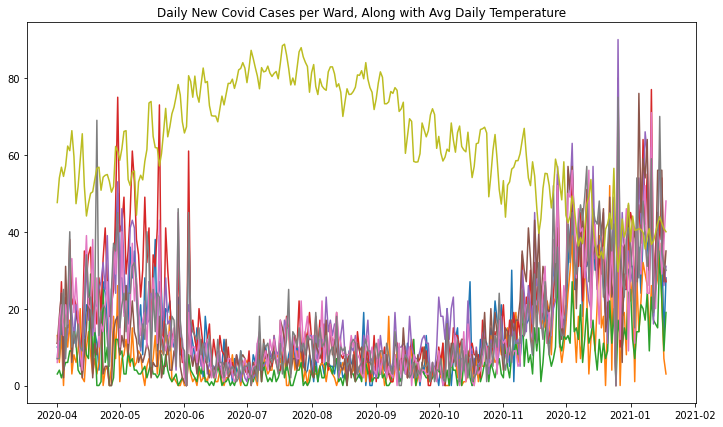

In [335]:
plt.figure(figsize=(12, 7))
plt.plot(model_df)
plt.title('Daily New Covid Cases per Ward, Along with Avg Daily Temperature');

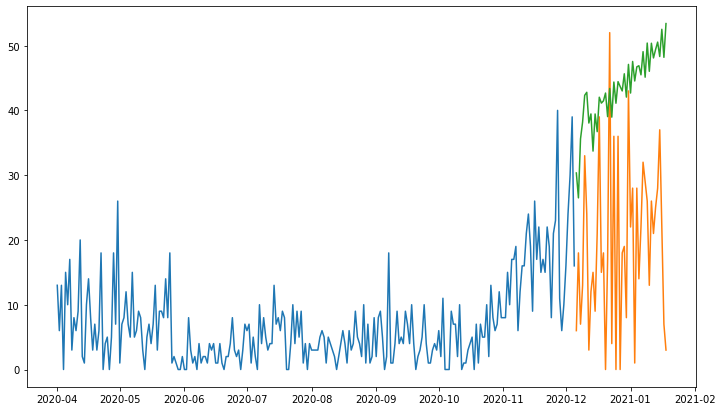

In [553]:
def plot_train_test_preds(train, test, original_model, ward, preds)
    plt.figure(figsize=(12, 7))
    plt.plot(model_df['Ward_2_Cases'][train.index[0]:train.index[-1]])
    plt.plot(model_df['Ward_2_Cases'][test.index[0]:test.index[-1]])
    plt.plot(ward_2_forecast_preds);

In [ ]:
evaluate_arima_model(train, test, endog_var, exog_var, order, forecast_steps)

In [499]:
feature = model_df['Ward_6_Cases'].values.reshape(-1, 1)

In [500]:
ss_test = StandardScaler()
feat_scaled = ss_test.fit_transform(feature)

In [501]:
predictions = ss_test.inverse_transform(predictions)

In [504]:
predictions = pd.Series(predictions, index=test.index)

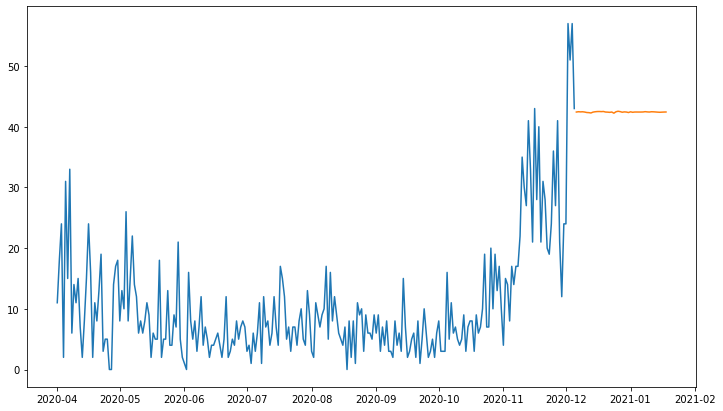

In [505]:
plt.figure(figsize=(12, 7))
plt.plot(model_df['Ward_6_Cases']['2020-04-01':'2020-12-05'])
plt.plot(predictions);

If using SARIMAX, set s = 7 (seasonality 7 day cycle, daily data)

In [491]:
predictions = pd.Series(predictions, index=test.index)

In [685]:
inversed = ss.inverse_transform(model_df_sc)
# pd.DataFrame(inversed, columns=model_df.columns)

In [ ]:
def evaluate_arima_model(X, arima_order):
    
    # prepare training dataset
#     train_size = int(len(X) * 0.66)
#     train, test = X[0:train_size], X[train_size:]

#     history = [x for x in train]
    
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

In [445]:
predictions = pd.Series(predictions, index=test.index)

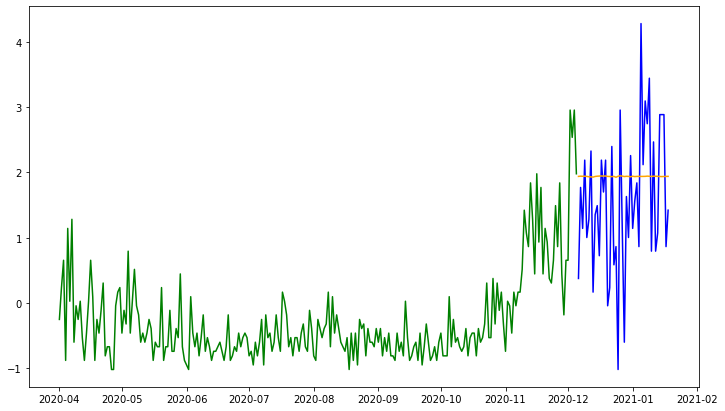

In [446]:
plt.figure(figsize=(12, 7))
plt.plot(train['Ward_6_Scaled'], c='g')
plt.plot(test['Ward_6_Scaled'], c='b')
plt.plot(predictions, c='orange');

In [434]:
mean_squared_error(test['Ward_8_Scaled'], ward_1_arimax_forecast[0])

1.878894952414452

In [418]:
# Testing
arimax = ARIMA(endog = train['Ward_2_Scaled'], 
                  exog = train['Avg_Temp_Scaled'],
                  dates = train.index, 
                  order = p_q_gs_ward_6).fit()

In [417]:
p_q_gs_ward_2

(4, 1, 5)

In [419]:
exog_forecast = test['Avg_Temp_Scaled']
arima_forecast = arimax.forecast(steps=len(test), exog=exog_forecast)

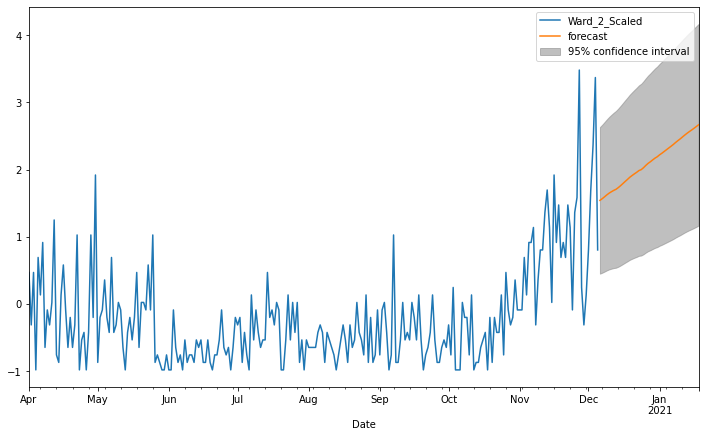

In [420]:
fig, ax = plt.subplots(figsize=(12, 7))
ax = train['Ward_2_Scaled'].plot(ax=ax)
fig = arimax.plot_predict(exog=exog_forecast, start=test.index[0], end=test.index[-1], dynamic=True,
                          plot_insample=False, ax=ax)
plt.show();

In [306]:
len(arima_forecast)

3

In [304]:
arimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:        D.Ward_1_Scaled   No. Observations:                  248
Model:                 ARIMA(5, 1, 2)   Log Likelihood                -219.681
Method:                       css-mle   S.D. of innovations              0.585
Date:                Tue, 26 Jan 2021   AIC                            459.361
Time:                        15:04:14   BIC                            494.496
Sample:                    04-02-2020   HQIC                           473.505
                         - 12-05-2020                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.0118      0.007      1.691      0.091      -0.002       0.025
Avg_Temp_Scaled          -0.0207      0.009     -2.368      0.018      -0.038      -0.004
ar.L1.D.Ward_1_Scaled    -0.9635      0.140     -6.879      0.000      -1.238      -0.689
ar.L2.D.Ward_1_Scaled    -0.0953      0.140     -0.680      0.497      -0.370       0.179
ar.L3.D.Ward_1_Scaled    -0.2043      0.119     -1.720      0.085      -0.437       0.028
ar.L4.D.Ward_1_Scaled    -0.3866      0.116     -3.319      0.001      -0.615      -0.158
ar.L5.D.Ward_1_Scaled    -0.1432      0.094     -1.521      0.128      -0.328       0.041
ma.L1.D.Ward_1_Scaled     0.1607      0.126      1.274      0.203      -0.087       0.408
ma.L2.D.Ward_1_Scaled    -0.6869      0.087     -7.882      0.000      -0.858      -0.516
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.8315           -1.0969j            1.3764           -0.1468
AR.2            0.8315           +1.0969j            1.3764            0.1468
AR.3           -1.3813           -0.0000j            1.3813           -0.5000
AR.4           -1.4907           -0.6680j            1.6336           -0.4329
AR.5           -1.4907           +0.6680j            1.6336            0.4329
MA.1           -1.0953           +0.0000j            1.0953            0.5000
MA.2            1.3292           +0.0000j            1.3292            0.0000
-----------------------------------------------------------------------------
"""

In [300]:
# plt.plot(arima_forecast[0], c='g')
# plt.plot(arima_forecast[1], c='r')
# plt.plot(arima_forecast[2], c='purple');

In [267]:
def evaluate_arimax(train, test, endog, exog, order):

    train_endog_values = train[endog].values
    train_exog_values = train[exog].values
    
    test_endog_values = test[endog].values
    test_exog_values = test[exog].values
    
    train_dates = train.index
    test_dates = test.index
    
    preds = []
    
    for x in range(len(test)):
        arimax = ARIMA(endog = train_endog_values, 
                      exog = train_exog_values,
                      dates = train_dates, 
                      order = order).fit()
        pred = arimax.forecast()[0]
        preds.append(pred)
        train_endog_values.append(test_endog_values[x])
        train_exog_values.append(test_exog_values[x])
        
    rmse = np.sqrt(mean_squared_error(test_endog_values, preds))
    
    return rmse

In [269]:
arimax = ARIMA(endog = train['Ward_1_Scaled'], 
                      exog = train['Avg_Temp_Scaled'],
                      dates = train.index, 
                      order = (5,1,2)).fit()

In [ ]:
def evaluate_forecast(y,pred):
    results = pd.DataFrame({'r2_score':r2_score(y, pred),
                           }, index=[0])
    results['mean_absolute_error'] = mean_absolute_error(y, pred)
    results['median_absolute_error'] = median_absolute_error(y, pred)
    results['mse'] = mean_squared_error(y, pred)
    results['msle'] = mean_squared_log_error(y, pred)
    results['mape'] = mean_absolute_percentage_error(y, pred)
    results['rmse'] = np.sqrt(results['mse'])
    return results

In [95]:
date_list =  pd.date_range(start, periods=65, freq ='D')

In [103]:
train.index

DatetimeIndex(['2020-04-01', '2020-04-02', '2020-04-03', '2020-04-04',
               '2020-04-05', '2020-04-06', '2020-04-07', '2020-04-08',
               '2020-04-09', '2020-04-10',
               ...
               '2020-10-02', '2020-10-03', '2020-10-04', '2020-10-05',
               '2020-10-06', '2020-10-07', '2020-10-08', '2020-10-09',
               '2020-10-10', '2020-10-11'],
              dtype='datetime64[ns]', name='Date', length=194, freq=None)

In [106]:
AR1_pred = pd.Series(AR1_pred)
AR1_pred.index=test.index

In [107]:
AR1_pred

Date
2020-10-12     6.195247
2020-10-13     7.991952
2020-10-14     9.002250
2020-10-15     9.570346
2020-10-16     9.889789
                ...    
2020-12-11    10.300178
2020-12-12    10.300178
2020-12-13    10.300178
2020-12-14    10.300178
2020-12-15    10.300178
Length: 65, dtype: float64

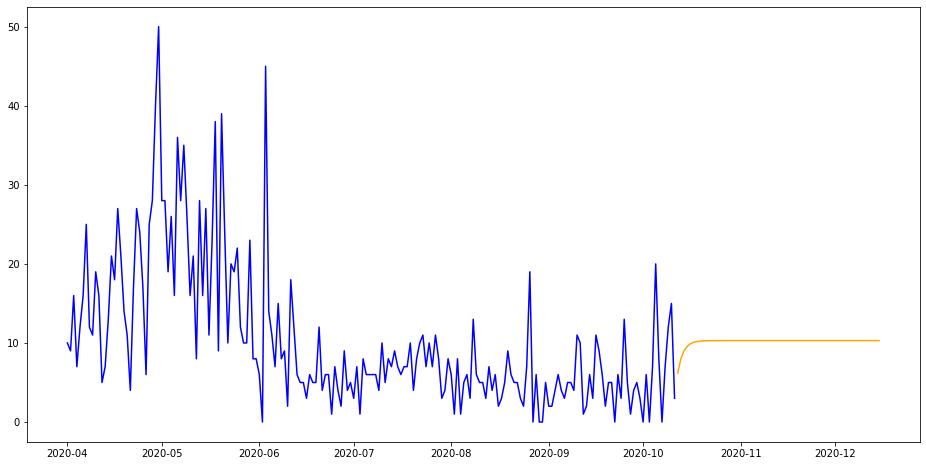

In [108]:
train_test_plot(train, AR1_pred)

In [66]:
# Calculate MSE
error = mean_squared_error(test_values, preds)
print(f'MSE: {round(error, 2)}')

MSE: 4209143.06


In [67]:
# Calculate residuals.
resids = test.values - AR1_pred

In [68]:
resids

array([ -3.19524663,   1.00804803,  -6.00224959,   6.42965431,
        17.11021065, -10.06941434,  -3.17041849,  -6.2272137 ,
        -8.25914996,   1.72289209,  -2.28720576,   1.70711616,
         0.70392334,  -4.297872  ,   4.70111847,   1.70055081,
        11.7002316 ,   6.70005212,   4.69995119,  10.69989444,
        -1.30013748,   3.69984458,   0.69983449,  -5.30017118,
        19.69982563,  -9.30017617,   7.69982282,  -0.30017774,
        -3.30017806,   2.69982176,   2.69982166,   5.6998216 ,
         6.69982157,  10.69982155,  -2.30017846,  19.69982153,
        10.69982153,  10.69982153,   4.69982153,   9.69982153,
         5.69982153,  10.69982153,   0.69982153,   0.69982153,
        21.69982153,  15.69982153,  28.69982153,  -0.30017847,
         6.69982153,   6.69982153,   6.69982153,  20.69982153,
        29.69982153,  36.69982153,  14.69982153,  14.69982153,
        24.69982153,  25.69982153,   7.69982153,  20.69982153,
        20.69982153,  22.69982153,  12.69982153,  31.69

In [69]:
test.index

DatetimeIndex(['2020-10-12', '2020-10-13', '2020-10-14', '2020-10-15',
               '2020-10-16', '2020-10-17', '2020-10-18', '2020-10-19',
               '2020-10-20', '2020-10-21', '2020-10-22', '2020-10-23',
               '2020-10-24', '2020-10-25', '2020-10-26', '2020-10-27',
               '2020-10-28', '2020-10-29', '2020-10-30', '2020-10-31',
               '2020-11-01', '2020-11-02', '2020-11-03', '2020-11-04',
               '2020-11-05', '2020-11-06', '2020-11-07', '2020-11-08',
               '2020-11-09', '2020-11-10', '2020-11-11', '2020-11-12',
               '2020-11-13', '2020-11-14', '2020-11-15', '2020-11-16',
               '2020-11-17', '2020-11-18', '2020-11-19', '2020-11-20',
               '2020-11-21', '2020-11-22', '2020-11-23', '2020-11-24',
               '2020-11-25', '2020-11-26', '2020-11-27', '2020-11-28',
               '2020-11-29', '2020-11-30', '2020-12-01', '2020-12-02',
               '2020-12-03', '2020-12-04', '2020-12-05', '2020-12-06',
      

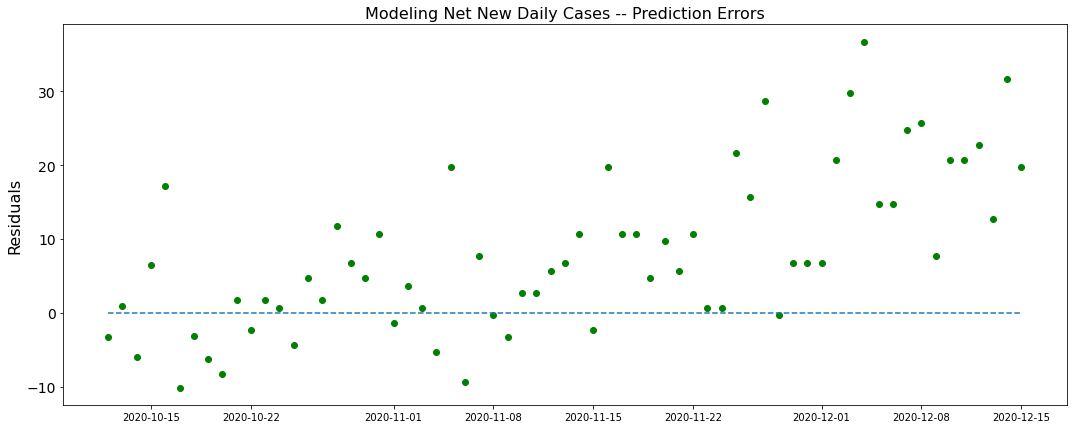

In [78]:
plt.figure(figsize=(18,7))

# Create residual scatterplot
plt.scatter(test.index, resids, c ='green')

# Plot horizontal line at y=0.
plt.hlines(y = 0,
           xmin = test.index.min(),
           xmax = test.index.max(),
           linestyles = '--')

# Set labels and axes.
plt.title('Modeling Net New Daily Cases -- Prediction Errors', fontsize=16)
# plt.xticks(fontsize=16)
# plt.xlim(test.index.min(), test.index.max())
plt.yticks(fontsize=14)
plt.ylabel('Residuals', fontsize = 16);

Residuals get larger around December, which is when a spike in new cases begins, suggesting the model doesn't see the spike coming. 

We know Winter months lead to increased cases since more people are going indoors. Indoor crowds make spreading easier. 

In [309]:
start = test.index[0]
start

Timestamp('2020-12-06 00:00:00')

In [308]:
end = test.index[-1]
end

Timestamp('2021-01-18 00:00:00')

In [84]:
# Fitting AR(2) model.
AR2 = ARIMA(endog = train_values,
            dates = train_dates,
            order = (2,0,0)).fit()

# Generate predictions.
AR2_pred = AR2.predict(start = start,
                       end = end)

# Evaluating our model on the train and test sets.
print(f'Training MSE: {mean_squared_error(train_values, AR2.predict())}')
print(f'Testing MSE: {mean_squared_error(test_values, AR2_pred)}')

Training MSE: 50.94762633932215
Testing MSE: 180.564015331123


In [ ]:
train_test_plot(train, preds)

In [244]:
def get_rolling_scaled_preds(train, test, endog_var, exog_var, order):

    predictions = []
    history_endog = list(train[endog_var])
    history_exog = list(train[exog_var])
    test_endog = test[endog_var]
    test_exog = test[exog_var]

    for t in range(len(test)):
        model_fit = ARIMA(endog=history_endog,
                          exog=history_exog,
                          dates=train.index,
                          order=order).fit()
        yhat = model_fit.forecast(steps=1, exog=test_exog[t])[0][0]
        predictions.append(yhat)
        history_endog.append(test_endog[t])
        history_exog.append(test_exog[t])
        
    return predictions

In [248]:
ward_4_rolling_scaled_preds = get_rolling_scaled_preds(train_sc,
                                                       test_sc, 
                                                       endog_var = 'Ward_4_Scaled',
                                                       exog_var = 'Avg_Temp_Scaled',
                                                       order = (2,1,5))

ward_4_inverse_sc_preds = inverse_transform_preds('Ward_4_Cases', 
                                                   model_df, 
                                                   scaled_preds = ward_4_rolling_scaled_preds, 
                                                   index = test_sc.index)